In [1]:
import torch
import gpytorch
import matplotlib.pyplot as plt

# Define the data points with a slightly wider range
train_x = torch.linspace(-0.5, 1.5, 100)
train_y = torch.sin(train_x * (2 * 3.1416)) + torch.randn(train_x.size()) * 0.2

# Create a GP model class
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMean()
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

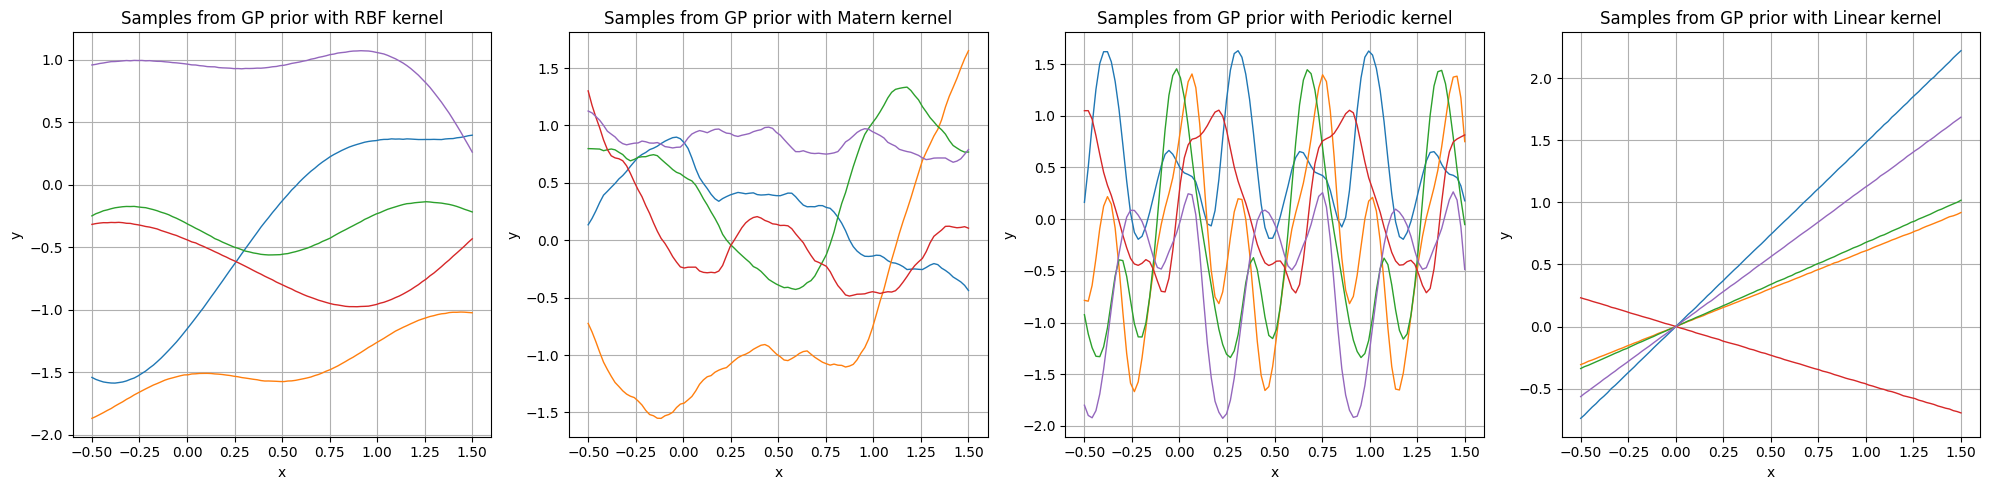

In [15]:
# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = ExactGPModel(train_x, train_y, likelihood)

# Set the model and likelihood to training mode
model.train()
likelihood.train()

# Define the number of samples to draw
num_samples = 5

# Define the covariance functions to use
kernel_names = ['RBF', 'Matern', 'Periodic', 'Linear']

# Plot the samples side by side
plt.figure(figsize=(20, 5))
for i, kernel_name in enumerate(kernel_names):
    with torch.no_grad():
        # Change the kernel based on the kernel_name
        if kernel_name == 'RBF':
            model.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        elif kernel_name == 'Matern':
            model.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5))
        elif kernel_name == 'Periodic':
            model.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel())
        elif kernel_name == 'Linear':
            model.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())

        # Sample from the GP prior
        samples = model(train_x).sample(sample_shape=torch.Size([num_samples]))

        # Plot the samples
        plt.subplot(1, len(kernel_names), i + 1)
        for j in range(num_samples):
            plt.plot(train_x.numpy(), samples[j].numpy(), linewidth=1)

        plt.title('Samples from GP prior with ' + kernel_name + ' kernel')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.grid(True)

plt.tight_layout()
plt.savefig("priors!")
plt.show()

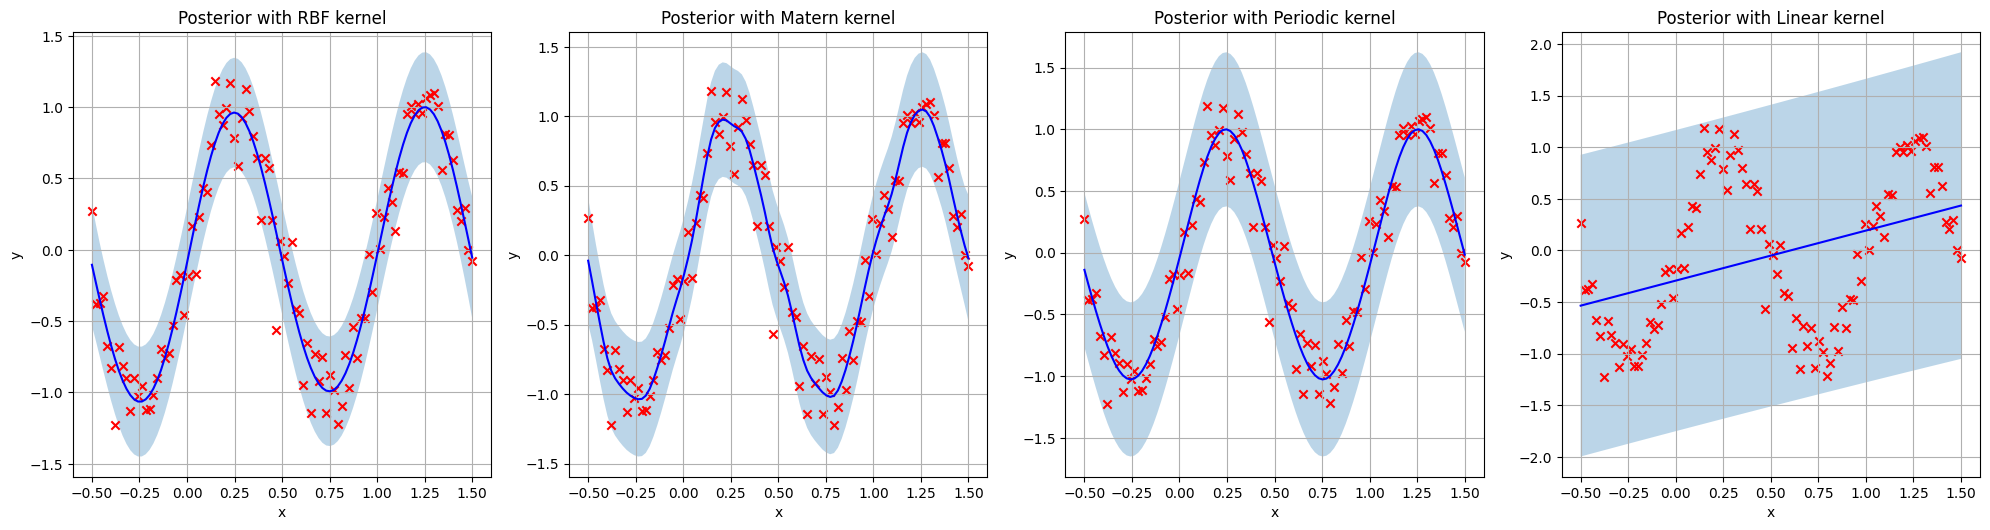

In [14]:
plt.close()
# Define the covariance functions to use
kernel_names = ['RBF', 'Matern', 'Periodic', 'Linear']
kernels = [
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=1.5)),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.PeriodicKernel()),
    gpytorch.kernels.ScaleKernel(gpytorch.kernels.LinearKernel())
]

# Initialize likelihood and model
likelihood = gpytorch.likelihoods.GaussianLikelihood()

# Plot the mean and variance before and after conditioning side by side
plt.figure(figsize=(20, 10))
for i, (kernel_name, kernel) in enumerate(zip(kernel_names, kernels)):
    model = ExactGPModel(train_x, train_y, likelihood)
    model.covar_module = kernel

    # Plot prior
    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.prior_mode():
        prior_pred = model(train_x)
        prior_mean = prior_pred.mean
        prior_lower, prior_upper = prior_pred.confidence_region()

    # Plot posterior after conditioning
    model.train()
    likelihood.train()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
    mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

    training_iterations = 50
    for _ in range(training_iterations):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y)
        loss.backward()
        optimizer.step()

    model.eval()
    likelihood.eval()
    with torch.no_grad(), gpytorch.settings.fast_pred_var():
        observed_pred = likelihood(model(train_x))
        post_mean = observed_pred.mean
        post_lower, post_upper = observed_pred.confidence_region()

    # Plot the prior mean and variance
    # plt.subplot(2, len(kernel_names), i + 1)
    # plt.plot(train_x.numpy(), prior_mean.detach().numpy(), 'b')
    # plt.fill_between(train_x.numpy(), prior_lower.numpy(), prior_upper.numpy(), alpha=0.3)
    # plt.title(f'Prior with {kernel_name} kernel')
    # plt.xlabel('x')
    # plt.ylabel('y')
    # plt.grid(True)

    # Plot the posterior mean and variance
    plt.subplot(2, len(kernel_names), i + 1 + len(kernel_names))
    plt.plot(train_x.numpy(), post_mean.numpy(), 'b')
    plt.fill_between(train_x.numpy(), post_lower.numpy(), post_upper.numpy(), alpha=0.3)
    plt.scatter(train_x.numpy(), train_y.numpy(), c='r', marker='x')  # Plot the training samples
    plt.title(f'Posterior with {kernel_name} kernel')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.grid(True)

plt.tight_layout()
plt.savefig("posteriors")
plt.show()  